In [13]:
import os
import json
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import numpy as np
from PIL import Image
# Helper utilities for legend processing

def _normalize_bbox(raw_bbox: Optional[object]) -> Optional[Dict[str, int]]:
    """Normalize various bbox formats into dict with x,y,width,height."""
    if raw_bbox is None:
        return None
    if isinstance(raw_bbox, dict):
        if {'x', 'y', 'width', 'height'}.issubset(raw_bbox.keys()):
            return {
                'x': int(raw_bbox['x']),
                'y': int(raw_bbox['y']),
                'width': int(raw_bbox['width']),
                'height': int(raw_bbox['height'])
            }
        if {'x1', 'y1', 'x2', 'y2'}.issubset(raw_bbox.keys()):
            x1, y1 = int(raw_bbox['x1']), int(raw_bbox['y1'])
            x2, y2 = int(raw_bbox['x2']), int(raw_bbox['y2'])
            return {'x': x1, 'y': y1, 'width': max(0, x2 - x1), 'height': max(0, y2 - y1)}
    if isinstance(raw_bbox, (list, tuple)) and len(raw_bbox) == 4:
        x, y, w, h = raw_bbox
        return {'x': int(x), 'y': int(y), 'width': int(w), 'height': int(h)}
    return None

def _scale_bbox_to_original(bbox: Dict[str, int], scale_x: float, scale_y: float, orig_w: int, orig_h: int) -> Dict[str, int]:
    """Scale bbox from resized coords back to original image coords and clamp."""
    if bbox is None:
        return None
    x = int(bbox['x'] * scale_x)
    y = int(bbox['y'] * scale_y)
    w = int(bbox['width'] * scale_x)
    h = int(bbox['height'] * scale_y)
    x = max(0, min(x, orig_w - 1))
    y = max(0, min(y, orig_h - 1))
    w = max(1, min(w, orig_w - x))
    h = max(1, min(h, orig_h - y))
    return {'x': x, 'y': y, 'width': w, 'height': h}


def save_legend_extraction_results(
    map_files: List[Path],
    legends_data: List[Dict],
    output_dir: Path,
    legends_dir: Path
) -> Dict:
    """
    Process all maps, extract legends with Gemini, and save results.
    Returns summary statistics.
    """
    
    results_summary = {
        'total_processed': 0,
        'legends_found': 0,
        'legends_saved': 0,
        'errors': []
    }
    
    all_legend_metadata = []
    
    for map_file, legend_info in zip(map_files, legends_data):
        results_summary['total_processed'] += 1
        has_legend = legend_info.get('has_legend', legend_info.get('legend_exists', False))
        
        if not has_legend:
            print(f"⊘ No legend found in {map_file.name}")
            continue
        
        results_summary['legends_found'] += 1
        
        try:
            # Load original map image
            original_img = Image.open(map_file)
            original_array = np.array(original_img)
            orig_h, orig_w = original_array.shape[:2]
            
            # Pull scale factors from legend_info
            scale_info = legend_info.get('_scale', {})
            scale_x = float(scale_info.get('sx', 1.0))
            scale_y = float(scale_info.get('sy', 1.0))
            orig_w = int(scale_info.get('orig_w', orig_w))
            orig_h = int(scale_info.get('orig_h', orig_h))
            
            # Normalize bbox variants
            raw_bbox = (legend_info.get('legend_bbox')
                        or legend_info.get('legend_bounding_box')
                        or legend_info.get('bounding_box')
                        or legend_info.get('bbox'))
            bbox = _normalize_bbox(raw_bbox)
            if not bbox:
                print(f"✗ Missing bounding box for legend in {map_file.name}; skipping save")
                continue
            
            # Scale bbox back to original size if we resized for inference
            scaled_bbox = _scale_bbox_to_original(bbox, scale_x, scale_y, orig_w, orig_h)
            legend_crop = extract_legend_crop_from_bbox(original_array, scaled_bbox)
            if legend_crop is None:
                print(f"✗ Invalid bbox for {map_file.name}; skipping save")
                continue
            
            # Save legend crop
            map_stem = map_file.stem.replace('_map', '')
            legend_output_path = legends_dir / f"{map_stem}_legend.png"
            
            legend_img = Image.fromarray(legend_crop)
            legend_img.save(legend_output_path)
            legend_info['legend_bbox'] = scaled_bbox
            legend_info['mask_available'] = False  # no SAM refinement per request
            legend_info['legend_image'] = legend_output_path.name
            all_legend_metadata.append(legend_info)
            
            results_summary['legends_saved'] += 1
            
            print(f"✓ Legend extracted from {map_file.name}")
            print(f"  Location: {legend_info.get('legend_location', 'unknown')}")
            print(f"  Items: {len(legend_info.get('legend_items', []))}")
            
        except Exception as e:
            error_msg = f"Error processing {map_file.name}: {str(e)}"
            results_summary['errors'].append(error_msg)
            print(f"✗ {error_msg}")
    
    # Save all metadata to JSON
    metadata_output = legends_dir / "legends_metadata.json"
    with open(metadata_output, 'w') as f:
        json.dump(all_legend_metadata, f, indent=2)
    
    print(f"\n{'='*60}")
    print("LEGEND EXTRACTION SUMMARY")
    print(f"{'='*60}")
    print(f"Total maps processed: {results_summary['total_processed']}")
    print(f"Legends found: {results_summary['legends_found']}")
    print(f"Legends saved: {results_summary['legends_saved']}")
    print(f"Metadata saved to: {metadata_output}")
    
    if results_summary['errors']:
        print(f"\nErrors encountered:")
        for err in results_summary['errors']:
            print(f"  - {err}")
    
    return results_summary





## Section 1: Import Required Libraries

In [14]:
import os
import json
import base64
import io
import re
from pathlib import Path
from typing import Optional, Dict, List, Tuple
from dataclasses import dataclass, asdict
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

# LLM providers
import yaml
from openai import OpenAI
import anthropic

# Google Gemini API
import google.generativeai as genai
from google.generativeai.types import GenerationConfig

# SAM2 for segmentation refinement
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 100

print("All libraries imported successfully!")

ModuleNotFoundError: No module named 'openai'

## Section 2: Set Up LLM Provider (Gemini / ChatGPT / Claude)

In [ ]:
# Load API keys and choose provider from apikey.yaml
yaml_path = Path("apikey.yaml")
if not yaml_path.exists():
    raise FileNotFoundError("apikey.yaml not found; add keys there.")

config_data = yaml.safe_load(open(yaml_path)) or {}

# Provider: gemini | openai | anthropic
LLM_PROVIDER = (config_data.get("llm_provider") or "gemini").strip().lower()

# Model names (as requested)
GEMINI_MODEL = "gemini-2.5-pro"
OPENAI_MODEL = "gpt-4.1-nano"
CLAUDE_MODEL = "claude-3-haiku-20240307"

# Keys
gemini_key = config_data.get("gemini_key")
openai_key = config_data.get("openai_api_key") or config_data.get("openai_key")
anthropic_key = config_data.get("anthropic_api_key") or config_data.get("claude_api_key")

# Configure the selected provider
gemini_model = None
openai_client = None
anthropic_client = None

if LLM_PROVIDER == "gemini":
    if not gemini_key:
        raise ValueError("gemini_key missing in apikey.yaml")
    genai.configure(api_key=gemini_key)
    gemini_model = genai.GenerativeModel(GEMINI_MODEL)
    print(f"✓ Using Gemini: {GEMINI_MODEL}")
elif LLM_PROVIDER == "openai":
    if not openai_key:
        raise ValueError("openai_api_key missing in apikey.yaml")
    openai_client = OpenAI(api_key=openai_key)
    print(f"✓ Using OpenAI: {OPENAI_MODEL}")
elif LLM_PROVIDER in {"anthropic", "claude"}:
    LLM_PROVIDER = "anthropic"
    if not anthropic_key:
        raise ValueError("anthropic_api_key (or claude_api_key) missing in apikey.yaml")
    anthropic_client = anthropic.Anthropic(api_key=anthropic_key)
    print(f"✓ Using Claude: {CLAUDE_MODEL}")
else:
    raise ValueError(f"Unsupported llm_provider: {LLM_PROVIDER}. Use gemini | openai | anthropic")

✓ Gemini 3.0 Flash configured from apikey.yaml


In [ ]:
def _image_to_png_base64(image_data: np.ndarray) -> Tuple[str, str]:
    """Return (media_type, base64_data) for the image payload."""
    img_pil = Image.fromarray(image_data)
    buf = io.BytesIO()
    img_pil.save(buf, format="PNG")
    b64 = base64.b64encode(buf.getvalue()).decode("utf-8")
    return "image/png", b64

def _extract_json_from_text(text: str) -> str:
    """Best-effort extraction of a JSON object from a text response."""
    if not text:
        raise ValueError("Empty response")
    text = text.strip()
    if text.startswith("{") and text.endswith("}"):
        return text
    start = text.find("{")
    end = text.rfind("}")
    if start == -1 or end == -1 or end <= start:
        raise ValueError(f"No JSON object found in response: {text[:200]}")
    return text[start:end+1]

def _legend_prompt() -> str:
    return """You are extracting the LEGEND/KEY from a historical zoning map image. Return STRICT JSON only.

REQUIREMENTS:
- Always include `has_legend` (bool)
- Always include `legend_bbox` with integer pixel coords: {"x": int, "y": int, "width": int, "height": int}
- Include `legend_location` (top-left | top-right | bottom-left | bottom-right | left | right | center | side)
- Include `legend_items` array with {identifier, symbol_pattern_type, visual_description, meaning}
- Include map metadata if visible: map_title, map_location, map_year, confidence_level
- If multiple legends/tables exist, merge into one bbox that covers them

Identify ANY legend/key/box/table that explains patterns, letters, or zone codes. Examples: boxes labeled LEGEND/KEY, tables of zone letters (A,B,C...), pattern explanations (hatching, dots, solid fills), or text summaries of zoning classes.

Output JSON schema:
{
  "has_legend": boolean,
  "legend_bbox": {"x": int, "y": int, "width": int, "height": int},
  "legend_location": string,
  "legend_items": [
    {"identifier": string, "symbol_pattern_type": string, "visual_description": string, "meaning": string}
  ],
  "map_title": string,
  "map_location": string,
  "map_year": string,
  "confidence_level": "high"|"medium"|"low"
}

Return ONLY valid JSON. Do not include markdown or extra text. Do not omit legend_bbox; if approximate, provide best guess."""

def extract_legend_with_llm(image_path: Path, image_data: np.ndarray) -> Dict:
    """
    Extract legend information using the configured provider (Gemini/OpenAI/Claude).
    Expects image_data to be the *resized* image array; bbox is relative to that resized image.
    """
    try:
        def _infer_bbox_from_location(img: np.ndarray, loc: Optional[str]) -> Optional[Dict[str, int]]:
            if loc is None:
                return None
            h, w = img.shape[:2]
            box_w, box_h = int(0.32 * w), int(0.32 * h)
            loc = (loc or "").lower()
            if "top" in loc and "left" in loc:
                x, y = int(0.05 * w), int(0.05 * h)
            elif "top" in loc and "right" in loc:
                x, y = max(0, w - box_w - int(0.05 * w)), int(0.05 * h)
            elif "bottom" in loc and "left" in loc:
                x, y = int(0.05 * w), max(0, h - box_h - int(0.05 * h))
            elif "bottom" in loc and "right" in loc:
                x, y = max(0, w - box_w - int(0.05 * w)), max(0, h - box_h - int(0.05 * h))
            elif "right" in loc:
                x, y = max(0, w - box_w - int(0.05 * w)), int(0.2 * h)
            elif "left" in loc:
                x, y = int(0.05 * w), int(0.2 * h)
            elif "center" in loc:
                x, y = int(0.34 * w), int(0.34 * h)
            else:
                x, y = max(0, w - box_w - int(0.05 * w)), max(0, h - box_h - int(0.05 * h))
            return {
                "x": int(np.clip(x, 0, w - 1)),
                "y": int(np.clip(y, 0, h - 1)),
                "width": int(min(box_w, w)),
                "height": int(min(box_h, h)),
            }

        def _normalize_bbox_local(raw_bbox: Optional[object]) -> Optional[Dict[str, int]]:
            if raw_bbox is None:
                return None
            if isinstance(raw_bbox, dict):
                if {'x', 'y', 'width', 'height'}.issubset(raw_bbox.keys()):
                    return {k: int(raw_bbox[k]) for k in ['x', 'y', 'width', 'height']}
                if {'x1', 'y1', 'x2', 'y2'}.issubset(raw_bbox.keys()):
                    x1, y1, x2, y2 = [int(raw_bbox[k]) for k in ['x1', 'y1', 'x2', 'y2']]
                    return {"x": x1, "y": y1, "width": max(0, x2 - x1), "height": max(0, y2 - y1)}
            if isinstance(raw_bbox, (list, tuple)) and len(raw_bbox) == 4:
                x, y, w_box, h_box = raw_bbox
                return {"x": int(x), "y": int(y), "width": int(w_box), "height": int(h_box)}
            return None

        prompt = _legend_prompt()

        # Provider-specific call
        if LLM_PROVIDER == "gemini":
            if gemini_model is None:
                raise RuntimeError("Gemini model not configured")
            img_pil = Image.fromarray(image_data)
            resp = gemini_model.generate_content(
                [prompt, img_pil],
                generation_config=GenerationConfig(
                    response_mime_type="application/json",
                    temperature=0.2,
                ),
            )
            raw_text = resp.text
        elif LLM_PROVIDER == "openai":
            if openai_client is None:
                raise RuntimeError("OpenAI client not configured")
            media_type, b64 = _image_to_png_base64(image_data)
            data_url = f"data:{media_type};base64,{b64}"
            # Prefer Responses API (new SDK); fall back if needed
            if hasattr(openai_client, "responses"):
                resp = openai_client.responses.create(
                    model=OPENAI_MODEL,
                    input=[
                        {
                            "role": "user",
                            "content": [
                                {"type": "input_text", "text": prompt},
                                {"type": "input_image", "image_url": data_url},
                            ],
                        }
                    ],
                    text={"format": {"type": "json_object"}},
                )
                raw_text = getattr(resp, "output_text", None) or str(resp)
            else:
                resp = openai_client.chat.completions.create(
                    model=OPENAI_MODEL,
                    messages=[
                        {
                            "role": "user",
                            "content": [
                                {"type": "text", "text": prompt},
                                {"type": "image_url", "image_url": {"url": data_url}},
                            ],
                        }
                    ],
                    temperature=0.2,
                    response_format={"type": "json_object"},
                )
                raw_text = resp.choices[0].message.content
        elif LLM_PROVIDER == "anthropic":
            if anthropic_client is None:
                raise RuntimeError("Anthropic client not configured")
            media_type, b64 = _image_to_png_base64(image_data)
            resp = anthropic_client.messages.create(
                model=CLAUDE_MODEL,
                max_tokens=1500,
                temperature=0.2,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": prompt},
                            {
                                "type": "image",
                                "source": {"type": "base64", "media_type": media_type, "data": b64},
                            },
                        ],
                    }
                ],
            )
            raw_text = "".join([b.text for b in resp.content if getattr(b, "type", None) == "text"])
        else:
            raise ValueError(f"Unsupported LLM_PROVIDER: {LLM_PROVIDER}")

        legend_data = json.loads(_extract_json_from_text(raw_text))
        legend_data['source_file'] = image_path.name

        raw_bbox = (legend_data.get('legend_bbox')
                    or legend_data.get('legend_bounding_box')
                    or legend_data.get('bounding_box')
                    or legend_data.get('bbox'))
        norm_bbox = _normalize_bbox_local(raw_bbox)
        if norm_bbox is None and legend_data.get('legend_location'):
            norm_bbox = _infer_bbox_from_location(image_data, legend_data.get('legend_location'))
        legend_data['legend_bbox'] = norm_bbox

        if 'legend_exists' in legend_data:
            legend_data['has_legend'] = bool(legend_data['legend_exists'])

        return legend_data

    except Exception as e:
        print(f"Error processing {image_path.name}: {str(e)}")
        return {
            'has_legend': False,
            'error': str(e),
            'source_file': image_path.name,
        }

## Section 3: Load and Preprocess Image Data

In [ ]:
# Setup directories
project_root = Path("/Users/rishabh/dev/econ-research")
input_dir = project_root / "input"
output_dir = project_root / "output"
legends_dir = project_root / "legends"
legends_dir.mkdir(exist_ok=True)

# Input preference: use input/ first (per request).
# If input/ is empty, fall back to output/*_map.png (common pipeline output).
input_images = sorted(input_dir.glob("*.png"))
fallback_maps = sorted(output_dir.glob("*_map.png"))
map_files = input_images if input_images else fallback_maps

print(f"Using {len(map_files)} images to process from: {(input_dir if input_images else output_dir)}")
for f in map_files[:20]:
    print(f"  - {f.name}")
if len(map_files) > 20:
    print(f"  ... and {len(map_files) - 20} more")

def load_and_preprocess_image(image_path: Path, max_size: int = 1024) -> Tuple[Image.Image, np.ndarray, float, float, Tuple[int, int]]:
    """
    Load image and preprocess for LLM vision analysis.
    Returns (resized PIL Image, np array, scale_x, scale_y, original_size).
    scale_x/scale_y map resized coords -> original coords by multiplication.
    """
    img = Image.open(image_path)
    orig_w, orig_h = img.size
    scale_x = scale_y = 1.0

    if max(img.size) > max_size:
        ratio = max_size / max(img.size)
        new_size = tuple(int(d * ratio) for d in img.size)
        img = img.resize(new_size, Image.Resampling.LANCZOS)
        scale_x = orig_w / img.size[0]
        scale_y = orig_h / img.size[1]

    if img.mode == 'RGBA':
        img = img.convert('RGB')

    img_array = np.array(img)
    return img, img_array, float(scale_x), float(scale_y), (int(orig_w), int(orig_h))

# Test loading
if map_files:
    test_img, test_arr, sx, sy, orig = load_and_preprocess_image(map_files[0])
    print(f"\n✓ Sample image loaded: {test_img.size}, dtype: {test_arr.dtype}, scale: ({sx:.3f}, {sy:.3f}), orig: {orig}")
else:
    print("\n⚠ No images found in input/ (or output fallback)")

Found 3 map images to process:
  - abilene-reporter-news-apr-29-1946-p-19_map.png
  - appleton-post-crescent-oct-24-1922-p-13_map.png
  - atchison-daily-globe-nov-30-1943-p-4_map.png

✓ Sample image loaded: (1017, 1024), dtype: uint8, scale: (3.539, 3.536), orig: (3599, 3621)


## Section 4: Extract Legend Using LLM (Gemini / ChatGPT / Claude)

In [ ]:
# Quick smoke-test on first image
if map_files:
    sample_path = map_files[0]
    print("Extracting legend from first image using configured provider...")
    print(f"Processing: {sample_path.name}\n")
    
    resized_img, resized_arr, sx, sy, (orig_w, orig_h) = load_and_preprocess_image(sample_path)
    legend_result = extract_legend_with_llm(sample_path, resized_arr)
    legend_result['_scale'] = {'sx': sx, 'sy': sy, 'orig_w': orig_w, 'orig_h': orig_h}
    
    print("Legend Extraction Result:")
    print(json.dumps(legend_result, indent=2))
else:
    print("⚠ No images available to process")

Extracting legend from first map with Gemini 2.5 Flash...
Processing: abilene-reporter-news-apr-29-1946-p-19_map.png



ValueError: too many values to unpack (expected 2)

## Section 5: Prepare Data for SAM Fine-tuning

In [ ]:
def extract_legend_crop_from_bbox(image: np.ndarray, bbox: Dict) -> Optional[np.ndarray]:
    """
    Extract legend region from image using bounding box from Gemini.
    bbox should have: x, y, width, height
    """
    try:
        h, w = image.shape[:2]
        x = int(bbox.get('x', 0))
        y = int(bbox.get('y', 0))
        width = int(bbox.get('width', w))
        height = int(bbox.get('height', h))
        
        # Validate bounds
        x = max(0, min(x, w))
        y = max(0, min(y, h))
        x2 = min(w, x + width)
        y2 = min(h, y + height)
        
        if x2 <= x or y2 <= y:
            return None
        
        # Extract crop
        crop = image[y:y2, x:x2]
        
        # Add padding (10% margin)
        pad = int(max(crop.shape[0], crop.shape[1]) * 0.05)
        pad_top = max(0, y - pad)
        pad_left = max(0, x - pad)
        pad_bottom = min(h, y2 + pad)
        pad_right = min(w, x2 + pad)
        
        padded_crop = image[pad_top:pad_bottom, pad_left:pad_right]
        
        return padded_crop
        
    except Exception as e:
        print(f"Error extracting crop: {e}")
        return None

# Prepare training data for SAM2
@dataclass
class LegendTrainingData:
    image_path: Path
    legend_region: np.ndarray
    bbox: Tuple[int, int, int, int]  # (x, y, x2, y2)
    metadata: Dict
    
def prepare_sam_training_data(map_files: List[Path], legends_data: List[Dict]) -> List[LegendTrainingData]:
    """
    Prepare training data for SAM2 fine-tuning.
    Returns list of LegendTrainingData objects with legend crops and bounding boxes.
    """
    training_data = []
    
    for map_file, legend_info in zip(map_files, legends_data):
        if not legend_info.get('has_legend', False):
            continue
            
        # Load full image
        img = Image.open(map_file)
        img_array = np.array(img)
        
        # Extract legend crop
        bbox = legend_info.get('legend_bbox')
        if not bbox:
            continue
            
        legend_crop = extract_legend_crop_from_bbox(img_array, bbox)
        if legend_crop is None:
            continue
        
        # Calculate precise bounding box in original image
        x = int(bbox.get('x', 0))
        y = int(bbox.get('y', 0))
        x2 = x + int(bbox.get('width', 0))
        y2 = y + int(bbox.get('height', 0))
        
        training_data.append(LegendTrainingData(
            image_path=map_file,
            legend_region=legend_crop,
            bbox=(x, y, x2, y2),
            metadata=legend_info
        ))
    
    return training_data

print("✓ SAM training data preparation functions ready")

## Section 6: Fine-tune SAM2 Model

In [ ]:
# Load SAM2 model
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

checkpoint = "sam2.1_hiera_base_plus.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"

try:
    sam2_model = build_sam2(model_cfg, checkpoint, device=device)
    sam_predictor = SAM2ImagePredictor(sam2_model)
    print("✓ SAM2 model loaded successfully!")
except Exception as e:
    print(f"⚠ Note: SAM2 loading may require specific setup. Error: {e}")
    print("Proceeding with legend extraction without SAM2 fine-tuning for now.")
    sam_predictor = None

def refine_legend_with_sam2(image: np.ndarray, bbox: Tuple[int, int, int, int]) -> Optional[np.ndarray]:
    """
    Use SAM2 to refine legend segmentation and create precise mask.
    bbox: (x, y, x2, y2)
    Returns binary mask of legend region.
    """
    if sam_predictor is None:
        return None
    
    try:
        # Set image for SAM2
        sam_predictor.set_image(image)
        
        # Convert bbox to center point and approximate area
        x, y, x2, y2 = bbox
        center_x, center_y = (x + x2) // 2, (y + y2) // 2
        
        # Use point prompt at center of bbox
        point_coords = np.array([[center_x, center_y]])
        point_labels = np.array([1])  # 1 = foreground
        
        # Generate mask
        masks, scores, logits = sam_predictor.predict(
            point_coords=point_coords,
            point_labels=point_labels,
            multimask_output=False
        )
        
        # Return the mask
        return masks[0]  # Binary mask
        
    except Exception as e:
        print(f"SAM2 refinement error: {e}")
        return None

print("✓ SAM2 refinement functions ready")

## Section 7: Save Extracted Legends to Output Folder

In [ ]:
def save_legend_extraction_results(
    map_files: List[Path],
    legends_data: List[Dict],
    output_dir: Path,
    legends_dir: Path
) -> Dict:
    """
    Process all maps, extract legends with configured LLM + SAM2, and save results.
    Returns summary statistics.
    """
    
    results_summary = {
        'total_processed': 0,
        'legends_found': 0,
        'legends_saved': 0,
        'errors': []
    }
    
    all_legend_metadata = []
    
    for map_file, legend_info in zip(map_files, legends_data):
        results_summary['total_processed'] += 1
        
        if not legend_info.get('has_legend', False):
            print(f"⊘ No legend found in {map_file.name}")
            continue
        
        results_summary['legends_found'] += 1
        
        try:
            # Load original map image
            original_img = Image.open(map_file)
            original_array = np.array(original_img)
            
            # Extract legend crop
            bbox = legend_info.get('legend_bbox')
            if not bbox:
                print(f"✗ Missing bounding box for legend in {map_file.name}; skipping save")
                continue
            
            # Apply scale metadata if available
            scale_info = legend_info.get('_scale', {})
            scale_x = float(scale_info.get('sx', 1.0))
            scale_y = float(scale_info.get('sy', 1.0))
            orig_w = int(scale_info.get('orig_w', original_array.shape[1]))
            orig_h = int(scale_info.get('orig_h', original_array.shape[0]))
            
            scaled_bbox = _scale_bbox_to_original(bbox, scale_x, scale_y, orig_w, orig_h)
            legend_crop = extract_legend_crop_from_bbox(original_array, scaled_bbox)
            if legend_crop is None:
                print(f"✗ Invalid bbox for {map_file.name}; skipping save")
                continue
            
            # Save legend crop
            map_stem = map_file.stem.replace('_map', '')
            legend_output_path = legends_dir / f"{map_stem}_legend.png"
            
            legend_img = Image.fromarray(legend_crop)
            legend_img.save(legend_output_path)
            
            legend_info['legend_bbox'] = scaled_bbox
            
            # Try SAM2 refinement if available
            bbox_tuple = (
                int(scaled_bbox.get('x', 0)),
                int(scaled_bbox.get('y', 0)),
                int(scaled_bbox.get('x', 0)) + int(scaled_bbox.get('width', 0)),
                int(scaled_bbox.get('y', 0)) + int(scaled_bbox.get('height', 0))
            )
            
            sam_mask = refine_legend_with_sam2(original_array, bbox_tuple)
            if sam_mask is not None:
                mask_output_path = legends_dir / f"{map_stem}_legend_mask.png"
                mask_img = Image.fromarray((sam_mask * 255).astype(np.uint8))
                mask_img.save(mask_output_path)
                legend_info['mask_available'] = True
            else:
                legend_info['mask_available'] = False
            
            # Save metadata
            legend_info['legend_image'] = legend_output_path.name
            all_legend_metadata.append(legend_info)
            
            results_summary['legends_saved'] += 1
            
            print(f"✓ Legend extracted from {map_file.name}")
            print(f"  Location: {legend_info.get('legend_location', 'unknown')}")
            print(f"  Items: {len(legend_info.get('legend_items', []))}")
            
        except Exception as e:
            error_msg = f"Error processing {map_file.name}: {str(e)}"
            results_summary['errors'].append(error_msg)
            print(f"✗ {error_msg}")
    
    # Save all metadata to JSON
    metadata_output = legends_dir / "legends_metadata.json"
    with open(metadata_output, 'w') as f:
        json.dump(all_legend_metadata, f, indent=2)
    
    print(f"\n{'='*60}")
    print("LEGEND EXTRACTION SUMMARY")
    print(f"{'='*60}")
    print(f"Total maps processed: {results_summary['total_processed']}")
    print(f"Legends found: {results_summary['legends_found']}")
    print(f"Legends saved: {results_summary['legends_saved']}")
    print(f"Metadata saved to: {metadata_output}")
    
    if results_summary['errors']:
        print(f"\nErrors encountered:")
        for err in results_summary['errors']:
            print(f"  - {err}")
    
    return results_summary

# Process all maps
print("Processing all maps for legend extraction...\n")

all_legends_data = []
for map_file in map_files:
    resized_img, resized_arr, sx, sy, (orig_w, orig_h) = load_and_preprocess_image(map_file)
    legend_data = extract_legend_with_llm(map_file, resized_arr)
    legend_data['_scale'] = {'sx': sx, 'sy': sy, 'orig_w': orig_w, 'orig_h': orig_h}
    legend_data['_provider'] = LLM_PROVIDER
    legend_data['_resized_size'] = resized_arr.shape[:2]
    all_legends_data.append(legend_data)

# Save results
summary = save_legend_extraction_results(map_files, all_legends_data, output_dir, legends_dir)

print(f"\n✓ All legend extractions saved to: {legends_dir}")

Displaying 3 extracted maps:



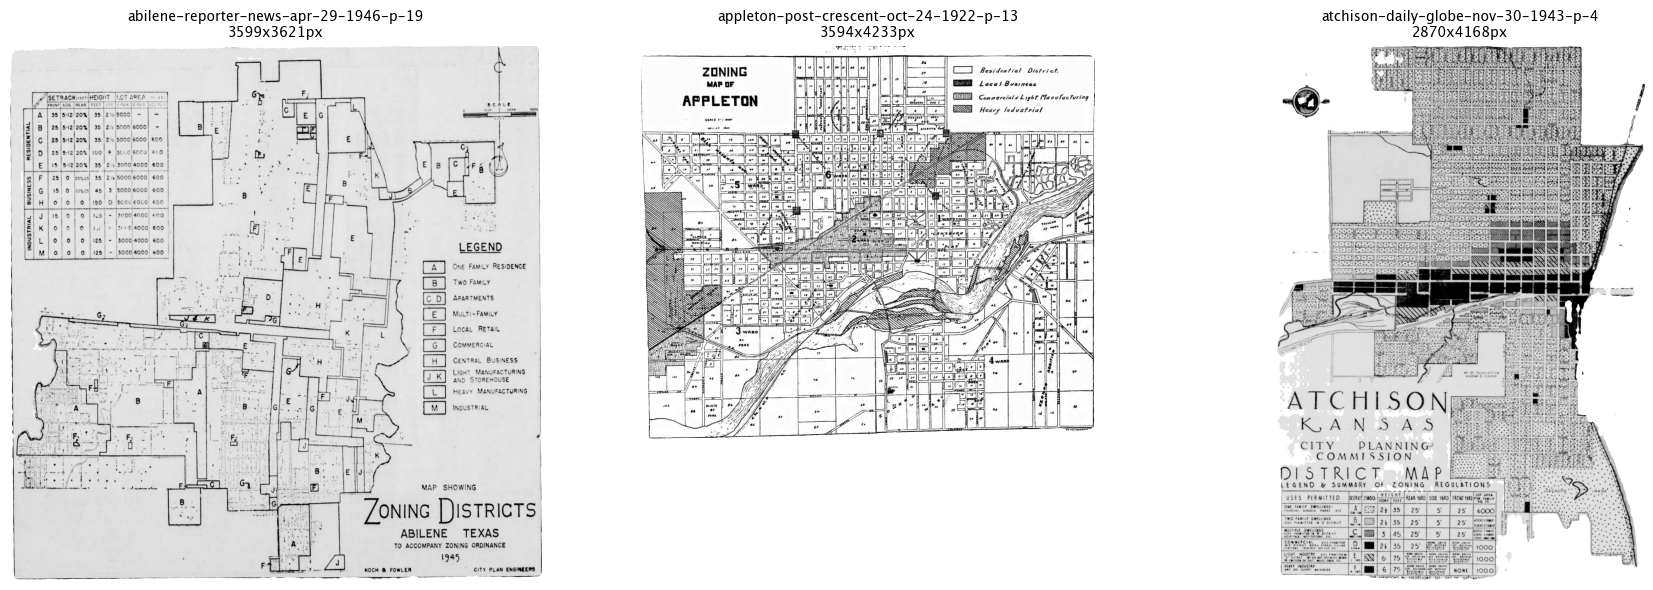

✓ Maps displayed

Found 3 extracted legends:

✓ abilene-reporter-news-apr-29-1946-p-19_legend.png (3599x2526px)
✓ appleton-post-crescent-oct-24-1922-p-13_legend.png (656x475px)
✓ atchison-daily-globe-nov-30-1943-p-4_legend.png (2133x1012px)


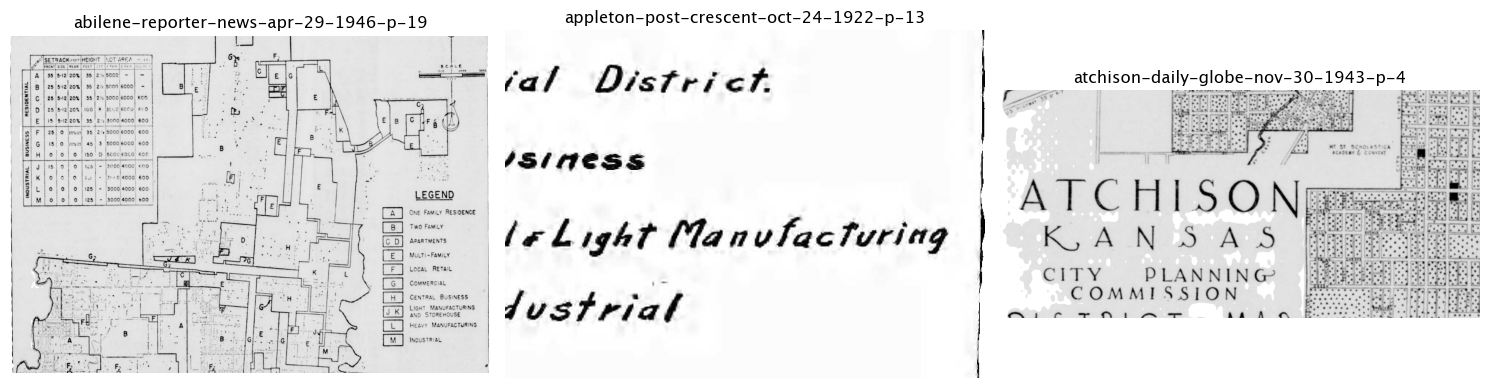


✓ Overview saved to: /Users/rishabh/dev/econ-research/legends/legends_overview.png

LEGEND METADATA SUMMARY

abilene-reporter-news-apr-29-1946-p-19_map.png
  Has legend: True
  Location: side
  Items: 22
    1. ONE FAMILY RESIDENCE (Unknown)
    2. TWO FAMILY (Unknown)
    3. APARTMENTS (Unknown)
    ... and 19 more items

appleton-post-crescent-oct-24-1922-p-13_map.png
  Has legend: True
  Location: top-right
  Items: 4
    1. Residential District (Unknown)
    2. Local Business (Unknown)
    3. Commercial & Light Manufacturing (Unknown)
    ... and 1 more items

atchison-daily-globe-nov-30-1943-p-4_map.png
  Has legend: True
  Location: bottom-left
  Items: 6
    1. One Family Dwellings (Uses permitted in "A" District, Churches, Schools, Parks, Etc.) (Unknown)
    2. Two Family Dwellings (Uses permitted in "B" District) (Unknown)
    3. Multiple Dwellings (Uses permitted in "C" District, Lot area not optional where 100% of emission or dust, noise or odor, etc.) (Unknown)
    ... and

In [ ]:
# First, display the actual map images to see what we're working with
map_files = sorted((project_root / "output").glob("*_map.png"))

if map_files:
    print(f"Displaying {len(map_files)} extracted maps:\n")
    
    fig, axes = plt.subplots(1, min(3, len(map_files)), figsize=(18, 6))
    if len(map_files) == 1:
        axes = [axes]
    else:
        axes = list(axes) if len(map_files) > 1 else [axes]
    
    for idx, map_file in enumerate(map_files):
        ax = axes[idx] if idx < len(axes) else None
        if ax is None:
            break
            
        map_img = Image.open(map_file)
        ax.imshow(map_img)
        
        map_name = map_file.stem.replace('_map', '')
        ax.set_title(f"{map_name}\n{map_img.size[0]}x{map_img.size[1]}px", fontsize=10, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"✓ Maps displayed")

# Now display extracted legends
legend_files = sorted(legends_dir.glob("*_legend.png"))

if legend_files:
    print(f"\n{'='*60}")
    print(f"Found {len(legend_files)} extracted legends:\n")
    
    # Create grid display
    n_cols = min(3, len(legend_files))
    n_rows = (len(legend_files) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    
    # Handle single or multiple subplots
    if len(legend_files) == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else list(axes)
    
    for idx, legend_file in enumerate(legend_files):
        ax = axes[idx]
        
        # Load and display legend
        legend_img = Image.open(legend_file)
        ax.imshow(legend_img)
        
        # Extract map name from filename
        map_name = legend_file.stem.replace('_legend', '')
        ax.set_title(f"{map_name}", fontsize=12, fontweight='bold')
        ax.axis('off')
        
        print(f"✓ {legend_file.name} ({legend_img.size[0]}x{legend_img.size[1]}px)")
    
    # Hide unused subplots
    for idx in range(len(legend_files), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(legends_dir / "legends_overview.png", dpi=100, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Overview saved to: {legends_dir / 'legends_overview.png'}")
else:
    print("\n⚠ No legend images found in legends directory")

# Display metadata summary
metadata_file = legends_dir / "legends_metadata.json"
if metadata_file.exists():
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    
    print(f"\n{'='*60}")
    print("LEGEND METADATA SUMMARY")
    print(f"{'='*60}")
    
    for item in metadata:
        source = item.get('source_file', 'Unknown')
        has_legend = item.get('has_legend', False)
        location = item.get('legend_location', 'unknown')
        num_items = len(item.get('legend_items', []))
        
        print(f"\n{source}")
        print(f"  Has legend: {has_legend}")
        print(f"  Location: {location}")
        print(f"  Items: {num_items}")
        
        if item.get('legend_items'):
            for i, leg_item in enumerate(item['legend_items'][:3], 1):  # Show first 3
                meaning = leg_item.get('meaning', 'Unknown')
                symbol_type = leg_item.get('symbol_type', 'Unknown')
                print(f"    {i}. {meaning} ({symbol_type})")
            
            if len(item['legend_items']) > 3:
                print(f"    ... and {len(item['legend_items']) - 3} more items")

## Visualize Extracted Legends